# HarvestStat Data Profiling - South Africa

In [1]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'EPSG:22234' # South Africa
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/ZA_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
#auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'South Africa',
    'product':['R011','R012','R013','R014','R015','R016','R017','R018'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, params=parameters, proxies={})#auth=auth, 
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
# ----------------------------------------------- #

# There is country-level (admin_0) data, however we are not sure the accuracy of it. Therefore, we exclude the contry-level data and process further. 
# *If this is country-level aggregation, the production values are too low. For example, ZA1994A0's annual maize production is less than 1 million metric ton.
# *The country-level data has "developing_sector_ps" crop_production_system.
df_country = df[df['fnid'] == 'ZA'].reset_index(drop=True)
df = df[df['fnid'] != 'ZA'].reset_index(drop=True)

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1994	 | ZA1994A1 | 9	| nan	| 0	| nan	| 0	|
----------------------------------------------- #


In [3]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# 2. Manual setting
# a) Add admin names to reporting units
admin_level = 'admin_1'
reporting_unit = df.loc[df['fnid'].map(lambda x: x[6] != 'A'), 'fnid'].unique()
df.loc[df.fnid.isin(reporting_unit),admin_level] = df.loc[df.fnid.isin(reporting_unit), 'locality_name'].map(lambda x: x.split(' ')[0])
# ----------------------------------------------- #

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority="Area Planted")
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([ZA_Admin1_1994], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 9,852
Removed 2,634 "Missing Value" points
0/2,463 "Area Harvested" points are retained.
2,410/2,463 "Area Planted" points are retained.
2,404/2,463 "Quantity Produced" points are retained.
2,404/2,463 "Yield" points are retained.
Current data points: 7,218

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1979 - 2022
10 grain types are found: Barley (Unspecified), Beans (mixed), Canola seed, Groundnuts (In Shell), Maize Grain (White), Maize Grain (Yellow), Sorghum, Soybean (unspecified), Sunflower Seed, Wheat Grain
2 seasons are found: Winter (04-01), Summer (04-01)
1 crop production system are found: Commercial (PS)
Data sources include:
[1] Crop Estimates Committee, South Africa --- CEC, South Africa
[2] FEWS NET, South Africa --- CEC, South Africa
Administrative-1 fnids: 9
Administrative-2 fnids: 0
0 reporting units are found: 

- Total production

- Southern Africa crop seasonal calendar

<img src="https://ipad.fas.usda.gov/rssiws/al/crop_calendar/images/safrica_sf_calendar.png"  width=900>

- In South Africa, basd on the FEWS NET data, there were four times of changes in administrative units: 1980, 1998, 2011, and 2012.

| Year | Admin-1 | # units  | Admin-2  | # units |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 1994  |**`ZA1994A1`** | 9  | nan      | 0 |

- Comparison between admin boundaries.

<img src="../figures/ZA_admin_shapes.png"  width=900>

- Here, we use **`ZA1994A1`** to represent all admin-level 1 crop data.
- South Africa has two crop seasons: `Summer (10-01)` and `Winter (05-01)`.
- South Africa has one crop production system: `Commercial (PS)`.

In [4]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = ZA_Admin1_1994.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
shape_used['ADMIN2'] = 'None'
shape_all['ADMIN2'] = 'None'
shape_latest['ADMIN2'] = 'None'
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area_new, prod_new = FDW_PD_Compiling(df, shape_used)
# ----------------------------------------------- #

In [5]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

# Save data
fn_out = '../data/crop/adm_crop_production_ZA.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')

All [country, season_name] are in the external season calendar.
../data/crop/adm_crop_production_ZA.csv is saved.


# Visualization of production data

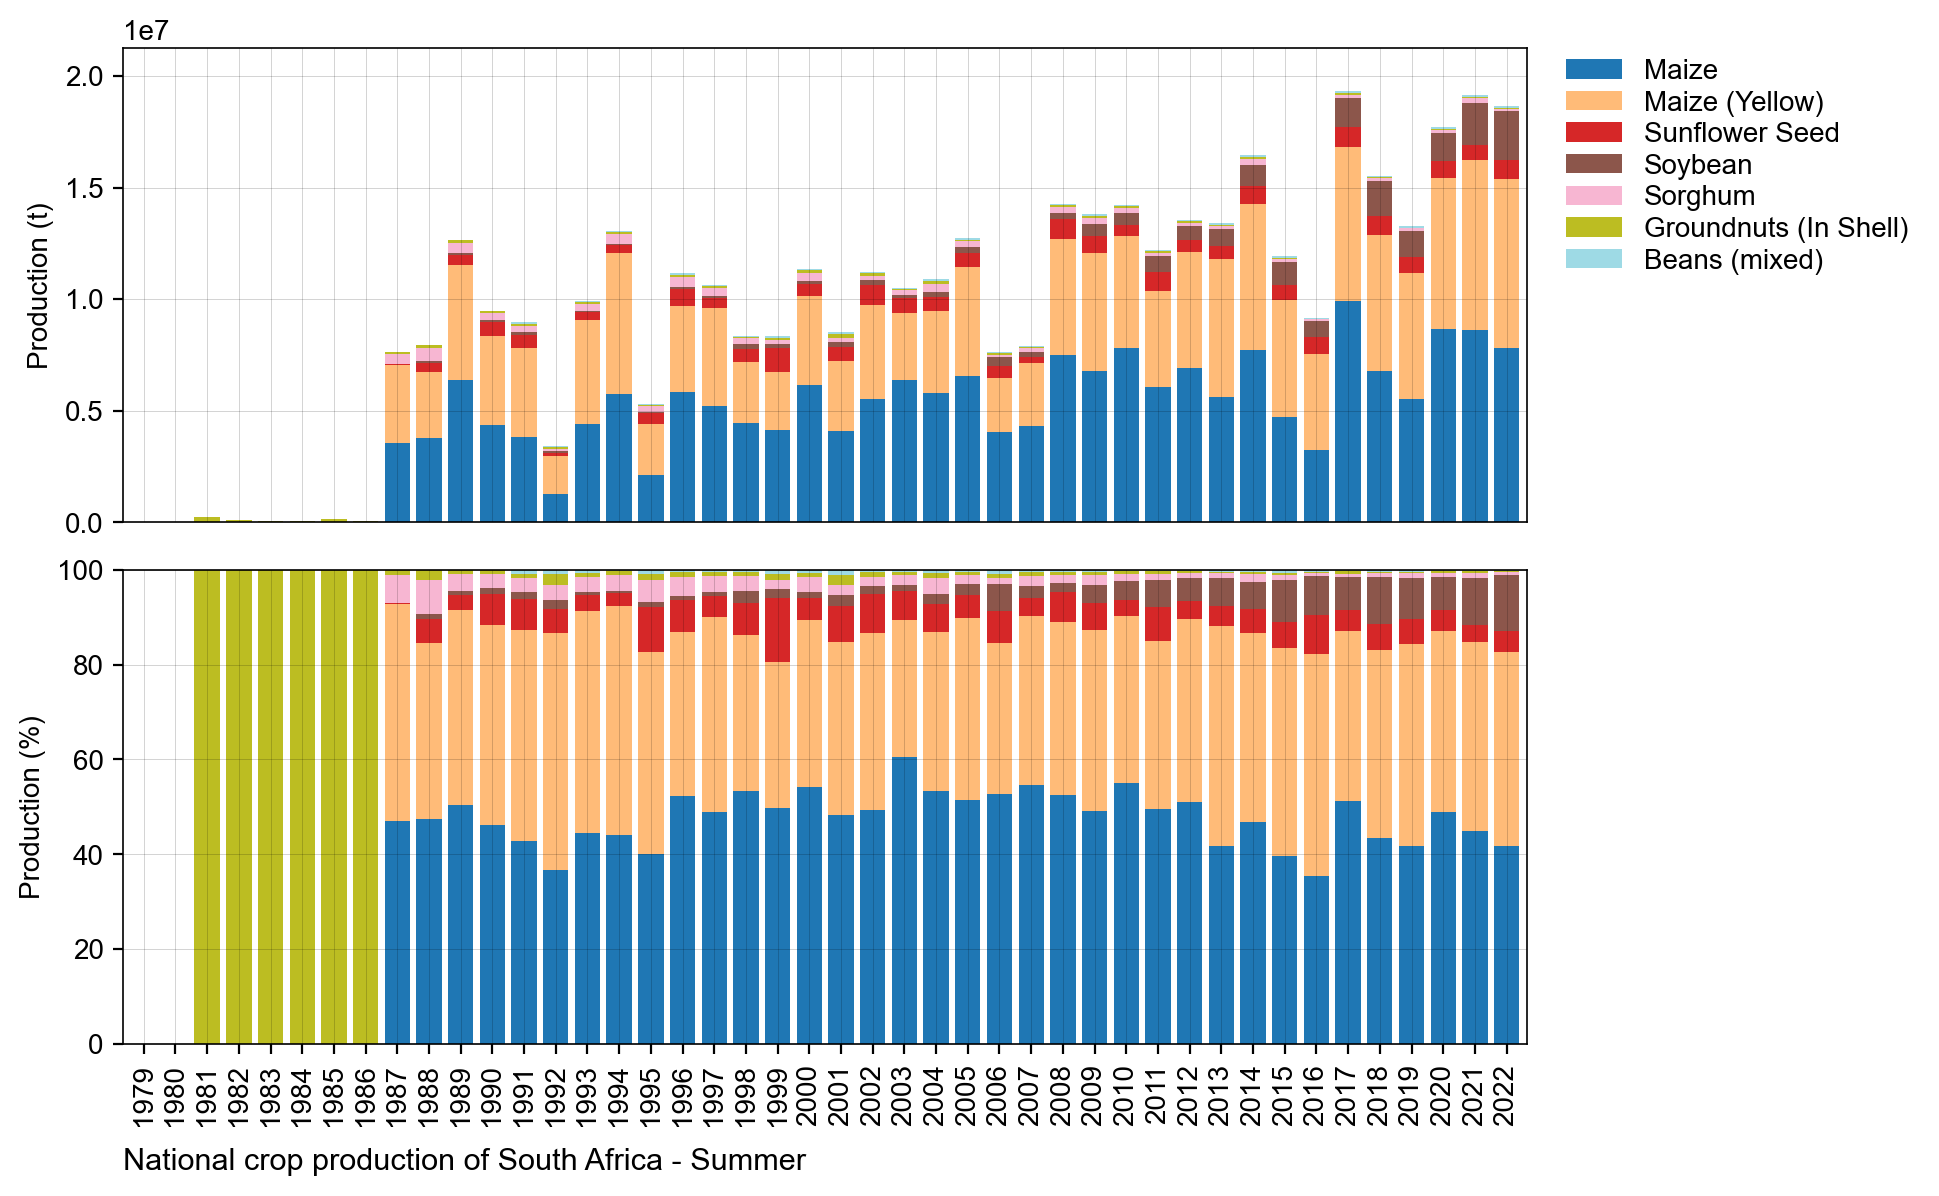

../figures/ZA_bar_natgrainprod_Summer.png is saved.


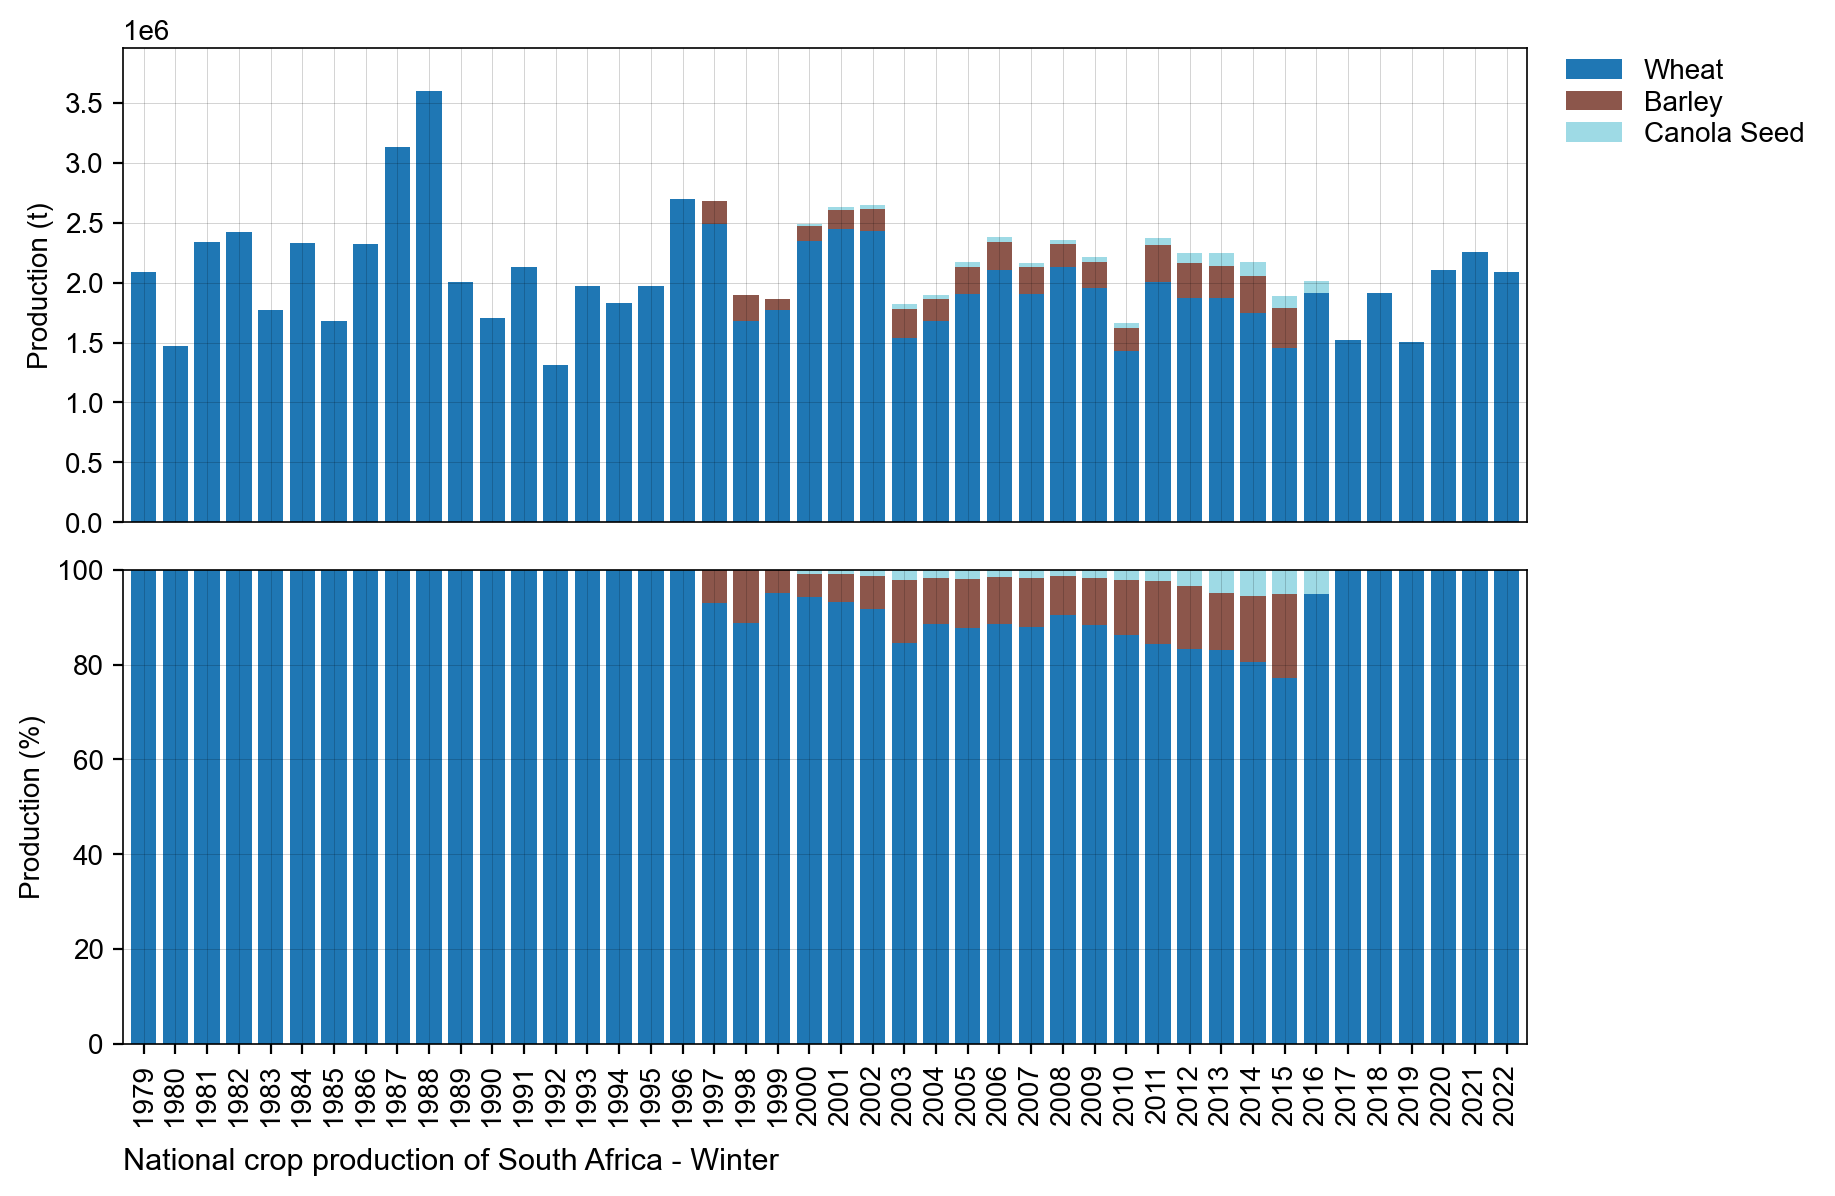

../figures/ZA_bar_natgrainprod_Winter.png is saved.


In [6]:
# Bar chart of national crop production
country_iso, country_name = 'ZA', 'South Africa'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Summer','Winter']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

No data to plot for Time-series of ZA - Maize (White) - Summer.


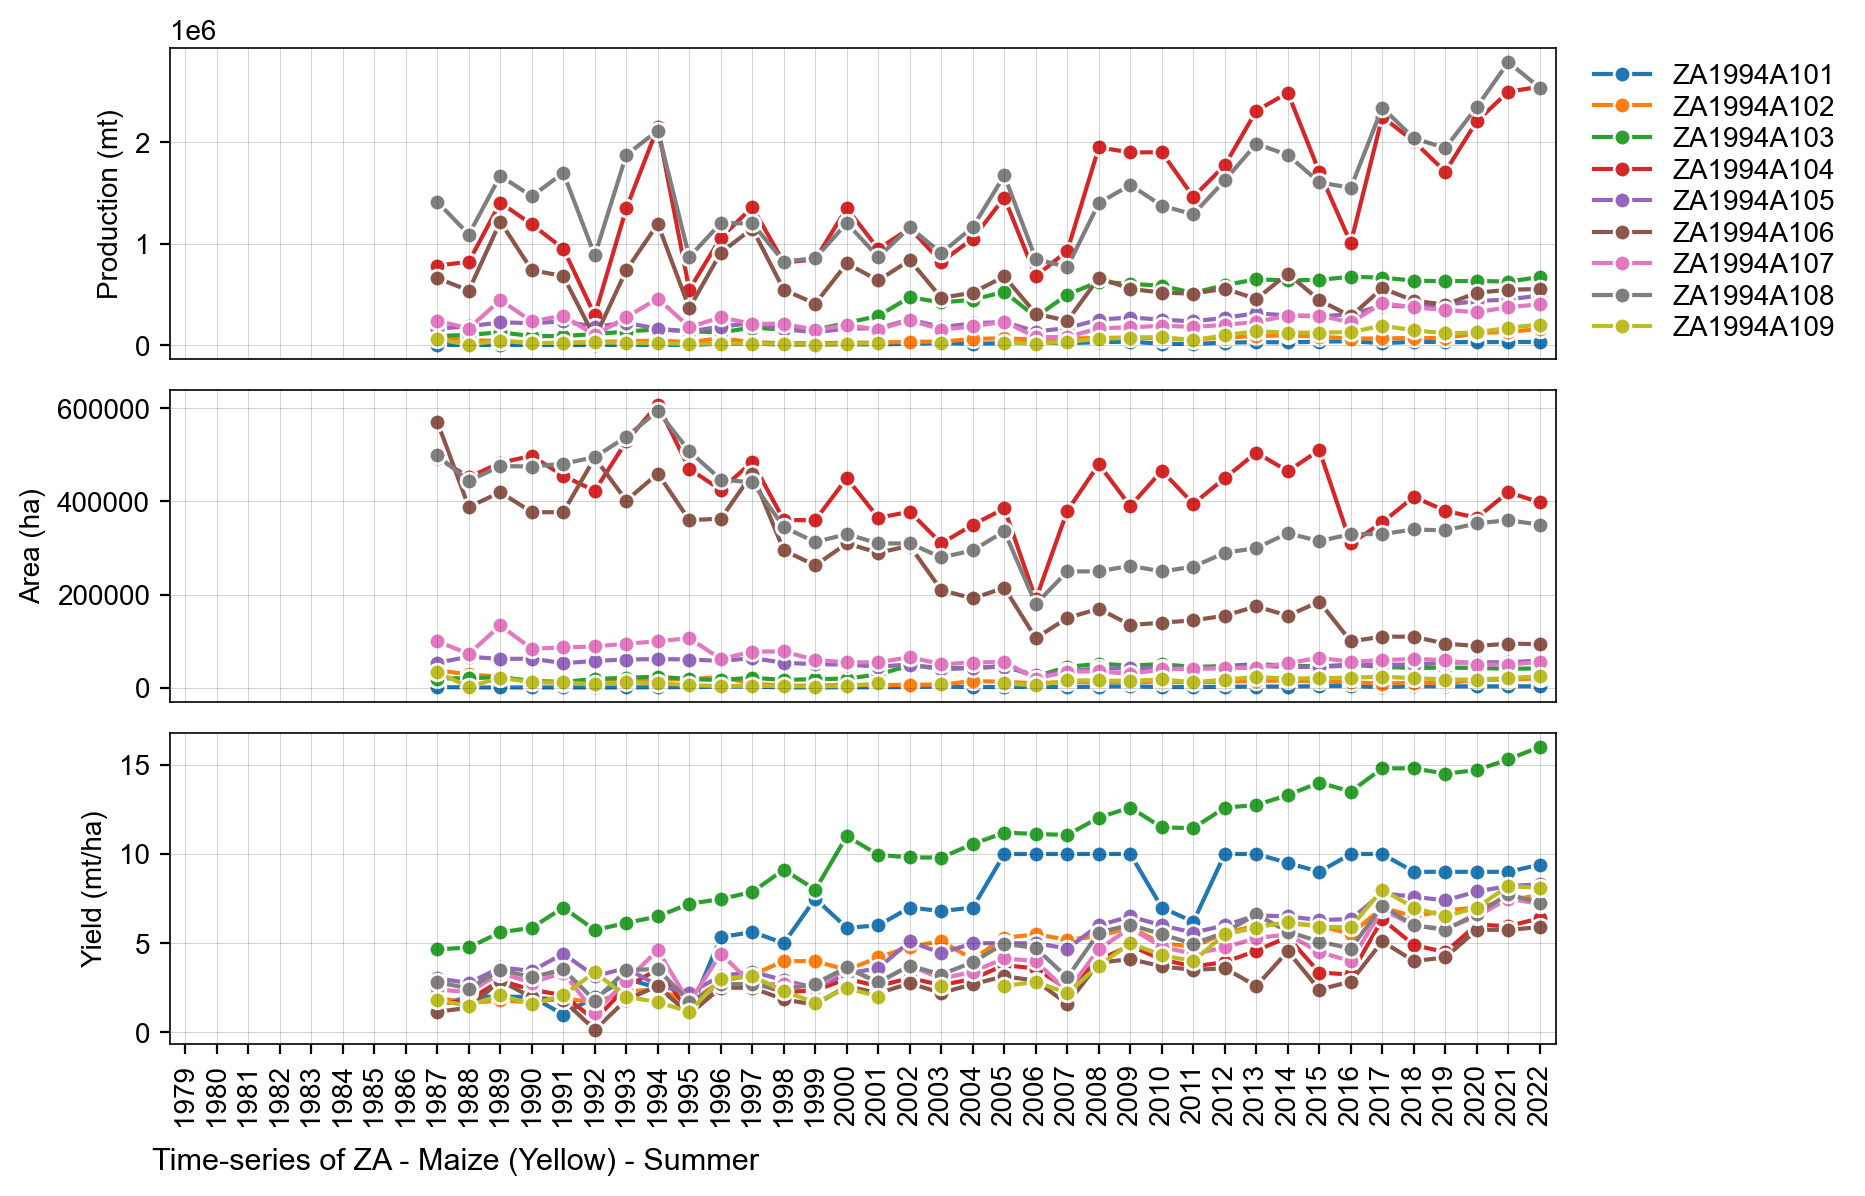

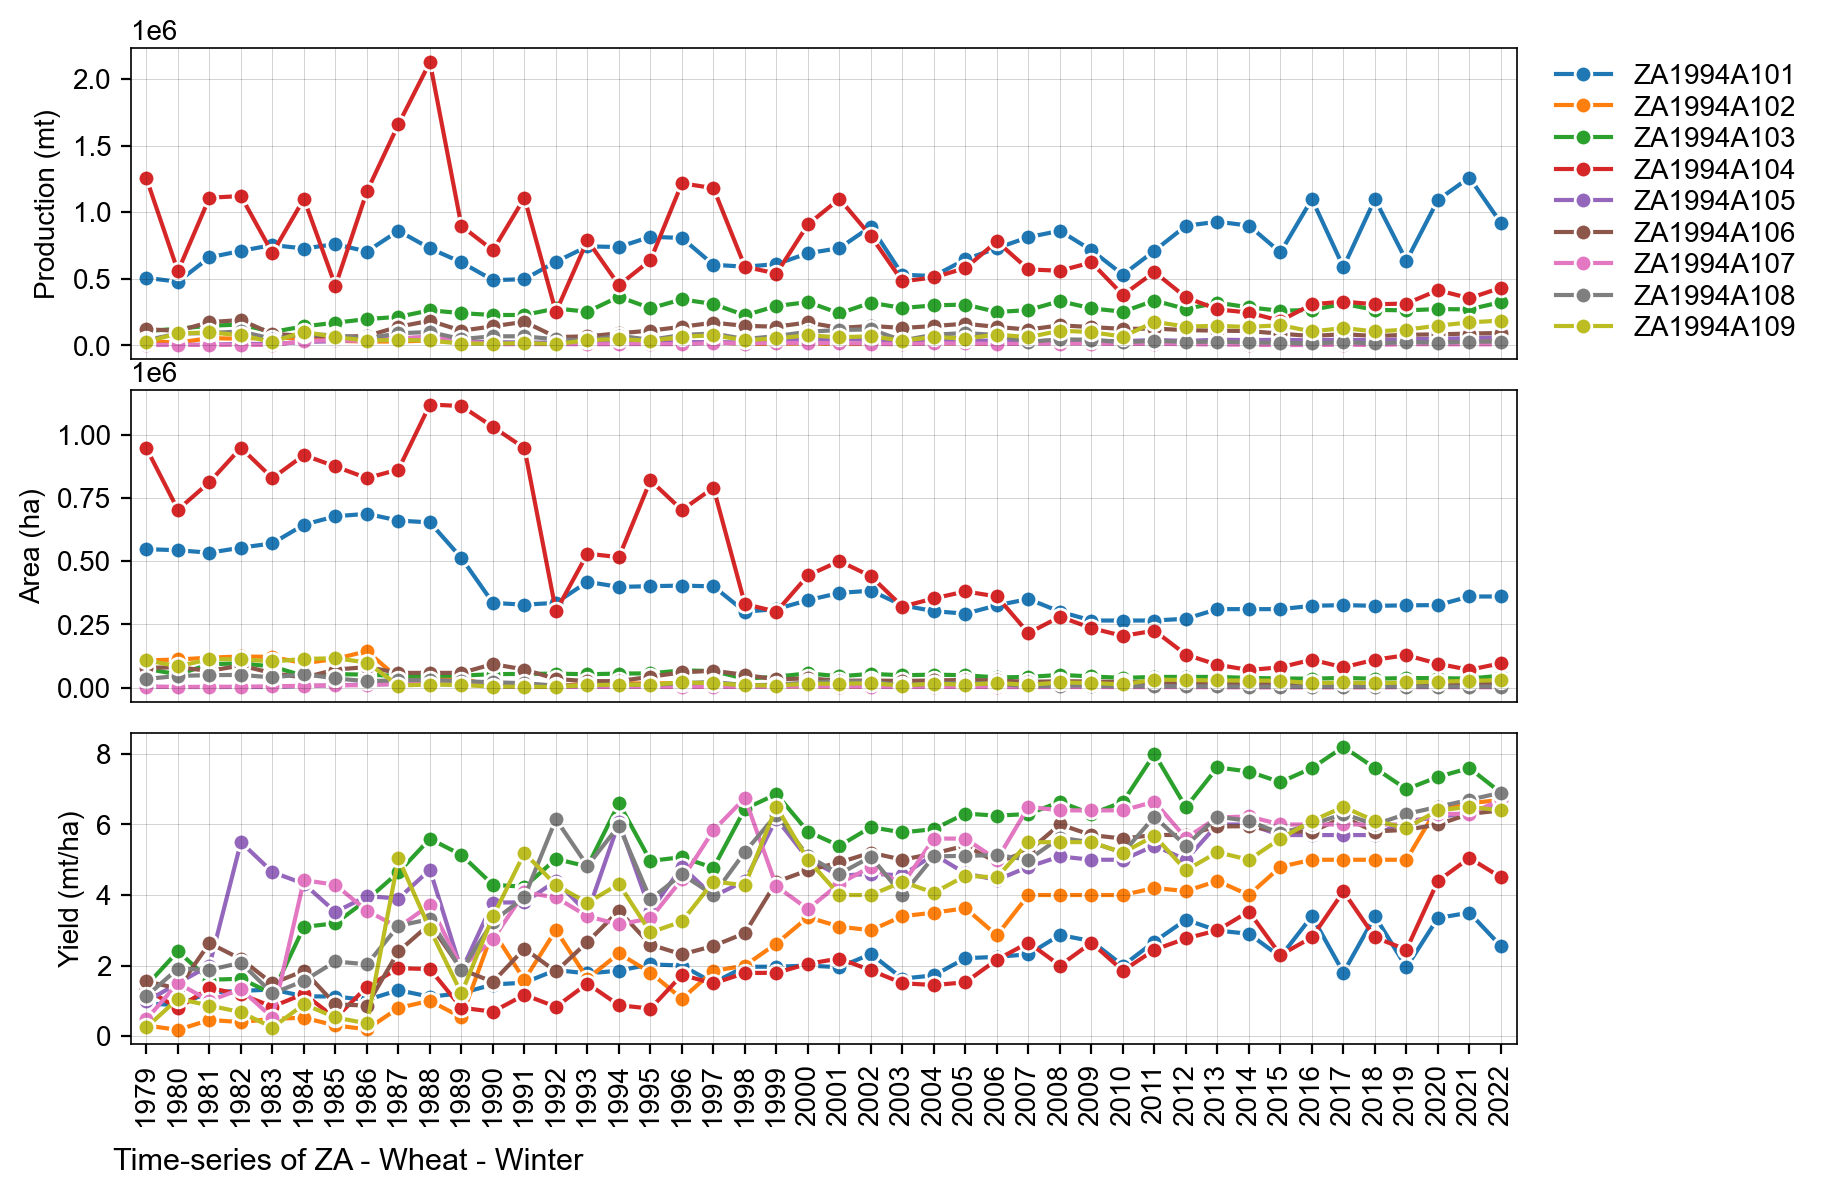

In [7]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'ZA', 'South Africa'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Maize (White)','Summer'],
    ['Maize (Yellow)','Summer'],
    ['Wheat','Winter'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)